In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import pylab as pl
import os
import geopandas as gp
from fiona.crs import from_epsg
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
benchmark = pd.read_excel("Cleaned_NYC_Benchmarking_2016.xlsx")
#benchmark.head()

In [ ]:
benchmark.columns

In [ ]:
print "There are %i primary property types" %len(pd.unique(benchmark["Primary Property Type"]))

In [4]:
benchmark = benchmark[['BBL', 'Zip Code', 'PrimPropType', 'LargePropUseType', 'LPUT_Area', 'YearBuilt', 'NumBldg', 'Occupancy', 
                       'Score', 'SourceEUI', 'Total_GHG_Emit']]
benchmark['SourceEUI'] = pd.to_numeric(benchmark['SourceEUI'], errors='coerce')
print len(benchmark)

13223


In [5]:
EUImean = benchmark['SourceEUI'].mean()
EUImedian = benchmark['SourceEUI'].median()
EUIstd = benchmark['SourceEUI'].std()
print "Mean EUI: ", EUImean
print "Median EUI: ",  EUImedian
print "Standard Deviation EUI: ", EUIstd

Mean EUI:  733.155476877
Median EUI:  129.2
Standard Deviation EUI:  11990.5642044


In [ ]:
#pd.tools.plotting.scatter_matrix (benchmark, s = 60, figsize=(16, 16))

In [ ]:
pl.scatter(benchmark['SourceEUI'], benchmark['Score'])
pl.title("ENERGY STAR Score as a Factor of Source EUI")
pl.xlabel("Weather Normalized Source EUI")
pl.ylabel("ENERGY STAR Score")

In [6]:
EUImax = EUImean + (3*EUIstd)
EUImin = EUImean - (3*EUIstd)
benchmark = benchmark[((benchmark['SourceEUI'] < EUImax) & 
                       (benchmark['SourceEUI'] > EUImin))]

In [7]:
benchmark = benchmark[(benchmark['SourceEUI'] != 0)]

In [ ]:
pl.scatter(benchmark['SourceEUI'], benchmark['Score'], alpha=0.5)
pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
pl.xlim(benchmark['SourceEUI'].min(), 1500)
pl.title("ENERGY STAR Score as a Factor of Source EUI")
pl.xlabel("Weather Normalized Source EUI")
pl.ylabel("ENERGY STAR Score")

In [ ]:
pl.scatter(benchmark['SourceEUI'], benchmark['Score'], alpha=0.5)
pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
pl.xlim(benchmark['SourceEUI'].min(), 250)
pl.title("ENERGY STAR Score as a Factor of Source EUI")
pl.xlabel("Weather Normalized Source EUI")
pl.ylabel("ENERGY STAR Score")

Intercept    58.633865
SourceEUI    -0.003865
dtype: float64


(0.10000000000000001, 1500)

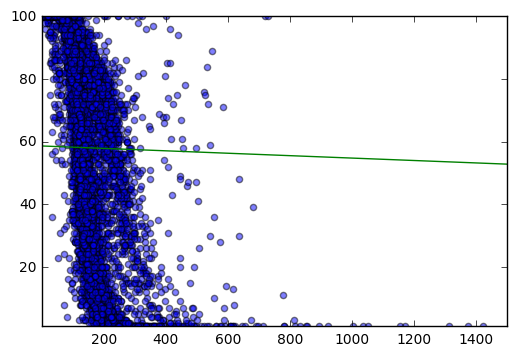

In [8]:
X=np.linspace(benchmark['SourceEUI'].min(), benchmark['SourceEUI'].max(), 1000)
model = smf.ols(formula = 'Score ~ SourceEUI', data = benchmark).fit()
print(model.params)
pl.plot(X, model.params[1]*X+model.params[0], color='green')
pl.scatter(benchmark['SourceEUI'], benchmark['Score'], alpha=0.5)
pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
pl.xlim(benchmark['SourceEUI'].min(), 1500)

In [ ]:
pl.plot(X, model.params[1]*X+model.params[0], color='green')
pl.scatter(benchmark['SourceEUI'], benchmark['Score'], alpha=0.5)
pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
pl.xlim(benchmark['SourceEUI'].min(), 250)

## Despite so much of the data being below 1500 Source EUI, the other data points are strong enough to seriously skew the regression.

Intercept    71.836197
SourceEUI    -0.094603
dtype: float64


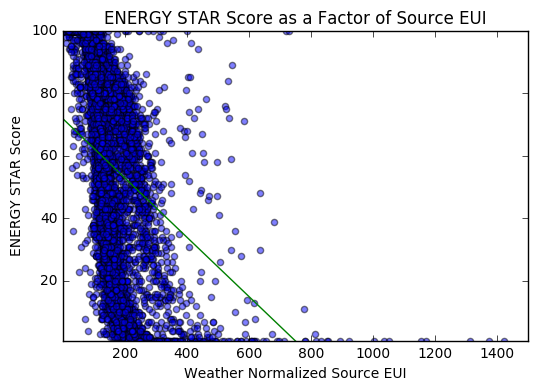

In [9]:
# Instead of just zooming in, delete everything above 1500
bmark = benchmark[((benchmark['SourceEUI'] < 10000))]
pl.scatter(bmark['SourceEUI'], bmark['Score'], alpha=0.5)
X=np.linspace(bmark['SourceEUI'].min(), bmark['SourceEUI'].max(), 1000)
model2 = smf.ols(formula = 'Score ~ SourceEUI', data = bmark).fit()
print(model2.params)
pl.plot(X, model2.params[1]*X+model2.params[0], color='green')
pl.ylim(bmark['Score'].min(), bmark['Score'].max())
pl.xlim(bmark['SourceEUI'].min(), 1500)
pl.title("ENERGY STAR Score as a Factor of Source EUI")
pl.xlabel("Weather Normalized Source EUI")
pl.ylabel("ENERGY STAR Score")

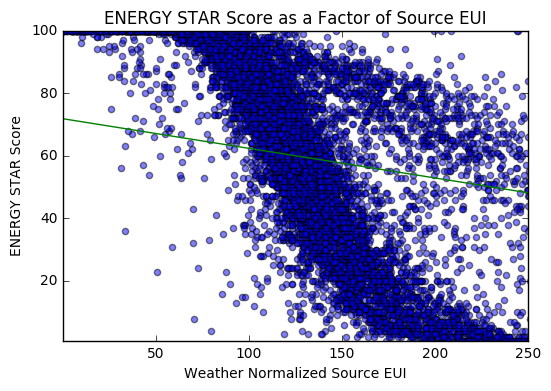

In [10]:
# Instead of just zooming in, delete everything above 1500
pl.scatter(bmark['SourceEUI'], bmark['Score'], alpha=0.5)
pl.plot(X, model2.params[1]*X+model2.params[0], color='green')
pl.ylim(bmark['Score'].min(), bmark['Score'].max())
pl.xlim(bmark['SourceEUI'].min(), 250)
pl.title("ENERGY STAR Score as a Factor of Source EUI")
pl.xlabel("Weather Normalized Source EUI")
pl.ylabel("ENERGY STAR Score")

## You have to get rid of a lot of the data in order to get a more reasonable looking regression line, and a moderately more meaningful coefficient 

In [11]:
model.summary(), model2.summary()

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                  Score   R-squared:                       0.013
 Model:                            OLS   Adj. R-squared:                  0.013
 Method:                 Least Squares   F-statistic:                     128.9
 Date:                Sat, 25 Mar 2017   Prob (F-statistic):           1.13e-29
 Time:                        15:30:47   Log-Likelihood:                -45683.
 No. Observations:                9492   AIC:                         9.137e+04
 Df Residuals:                    9490   BIC:                         9.138e+04
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
 ---------------------------------------------------------------------

## R-Squared from model1 is 0.013, R-Squared from model2 is 0.151 --> neither particularly good, suggesting Source EUI isn't actually a good predictor of Energy Star Score

In [25]:
model3 = smf.ols(formula = 'Score ~ SourceEUI + Total_GHG_Emit', data = benchmark).fit()
print(model3.params)
print model3.summary()

Intercept         58.645844
SourceEUI         -0.004291
Total_GHG_Emit     0.000037
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     64.96
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           9.50e-29
Time:                        15:50:57   Log-Likelihood:                -45671.
No. Observations:                9490   AIC:                         9.135e+04
Df Residuals:                    9487   BIC:                         9.137e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------

## Also a poor indicator

(1850, 2019)

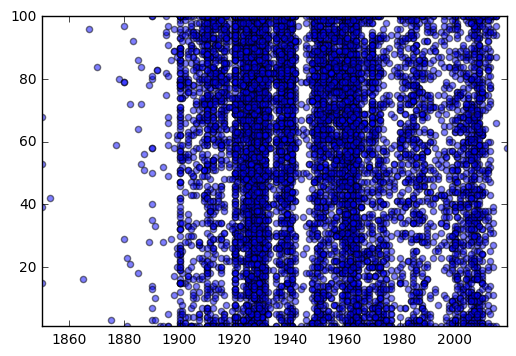

In [28]:
#X=np.linspace(benchmark['YearBuilt'].min(), benchmark['YearBuilt'].max(), 1000)
#model4 = smf.ols(formula = 'Score ~ YearBuilt', data = benchmark).fit()
#print(model4.params)
pl.plot(X, model4.params[1]*X+model4.params[0], color='green')
pl.scatter(benchmark['YearBuilt'], benchmark['Score'], alpha=0.5)
pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
pl.xlim(1850, benchmark['YearBuilt'].max())

# Have to turn year into age?

In [ ]:
benchmark['Age'] = 2016 - benchmark['YearBuilt']
#benchmark.head(6)

In [ ]:
#X=np.linspace(benchmark['Age'].min(), benchmark['Age'].max(), 1000)
#model4 = smf.ols(formula = 'Score ~ Age', data = benchmark).fit()
#print(model4.params)
#pl.plot(X, model4.params[1]*X+model4.params[0], color='green')
#pl.scatter(benchmark['Age'], benchmark['Score'], alpha=0.5)
#pl.ylim(benchmark['Score'].min(), benchmark['Score'].max())
#pl.xlim(benchmark['Age'].min(), 120)
#model4.summary()

In [42]:
model5 = smf.ols(formula = 'Score ~ SourceEUI + Occupancy + Total_GHG_Emit', data = benchmark).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     46.94
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           4.20e-30
Time:                        16:13:41   Log-Likelihood:                -45666.
No. Observations:                9490   AIC:                         9.134e+04
Df Residuals:                    9486   BIC:                         9.137e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         79.0494      6.230     12.688      0.000        66.837    91.262
SourceEUI         -0.0044      0.001     -8.260      0.000        -0.005    -0.003
Occupancy         -0.2055      0.063     -3.279      0.001        -0.328    -0.083
Total_GHG_Emit  3.809e-05   3.46e-05      1.101      0.271     -2.97e-05     0.000
==============================================================================
Omnibus:                     2771.121   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.826
Skew:                          -0.371   Prob(JB):                    3.15e-139
Kurtosis:                       1.969   Cond. No.                     2.81e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Zipcodes

In [53]:
zipcodes = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/zipcodes.geojson")

In [54]:
zipcodes = zipcodes[['geometry', 'postalCode']]
zipcodes.rename(columns = {'postalCode':'ZipCode'}, inplace=True)
zipcodes['ZipCode'] = pd.to_numeric(zipcodes['ZipCode'], errors = 'coerce')

In [55]:
zipcodes['area'] = zipcodes.to_crs(epsg=2263).geometry.area/(2.788*10**7)

In [48]:
benchmark.rename(columns={'Zip Code':'ZipCode'}, inplace=True)

In [58]:
print len(pd.unique(benchmark["ZipCode"])), len(pd.unique(zipcodes['ZipCode']))

189 247


In [59]:
type(zipcodes['ZipCode'][1])

numpy.int64

In [ ]:
benchmark['ZipCode'] = benchmark['ZipCode'].fillna(0.0).astype(int)

In [60]:
type(benchmark['ZipCode'][1])

numpy.int64

In [63]:
energy = pd.merge(zipcodes, benchmark, on='ZipCode', how='left')
len(energy)

11609

In [64]:
len(pd.unique(energy['ZipCode']))

247

In [65]:
energy.head()

,geometry,ZipCode,area,BBL,PrimPropType,LargePropUseType,LPUT_Area,YearBuilt,NumBldg,Occupancy,Score,SourceEUI,Total_GHG_Emit,Age
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.724037,4.012450e+09,Multifamily Housing,Multifamily Housing,106308.0,1936,1.0,95.0,88.0,96.8,435.5,80
1,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.724037,4.012490e+09,Multifamily Housing,Multifamily Housing,176000.0,1951,1.0,100.0,79.0,117.3,907.8,65
2,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.724037,4.012490e+09,Multifamily Housing,Multifamily Housing,107952.0,1937,1.0,100.0,41.0,132.1,655.7,79
3,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.724037,4.012510e+09,Multifamily Housing,Multifamily Housing,106108.0,1950,1.0,100.0,NaN,89.1,458.1,66
4,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0.724037,4.012540e+09,Multifamily Housing,Multifamily Housing,195615.0,1951,5.0,100.0,48.0,146.5,1231.7,65


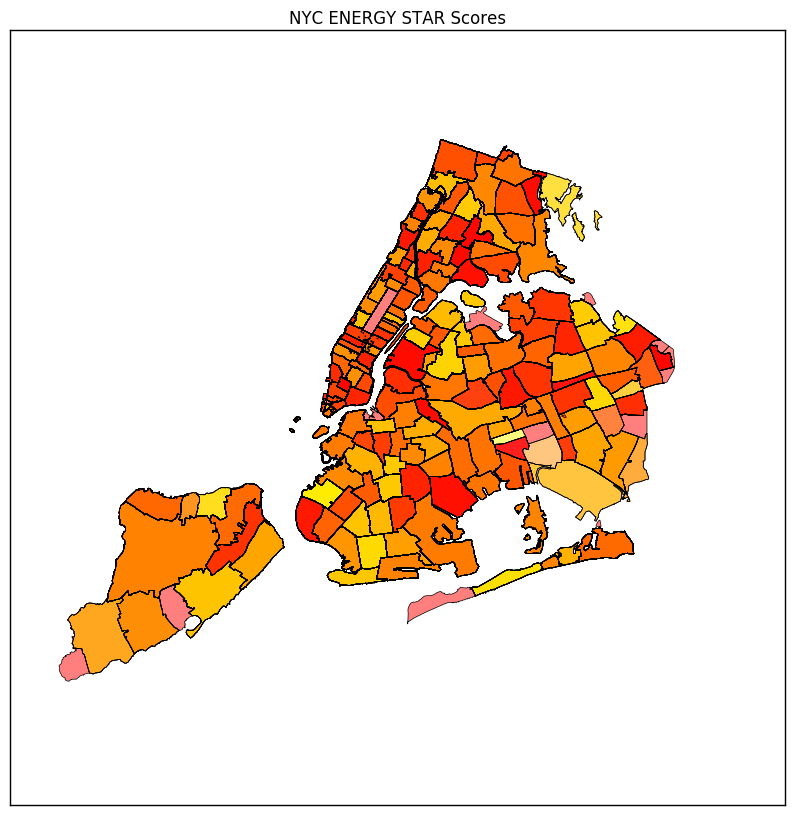

In [71]:
f, ax = plt.subplots(figsize=(7, 7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('NYC ENERGY STAR Scores')
energy.plot(column='Score', colormap='autumn', alpha=0.5,linewidth=0.5,ax=ax)

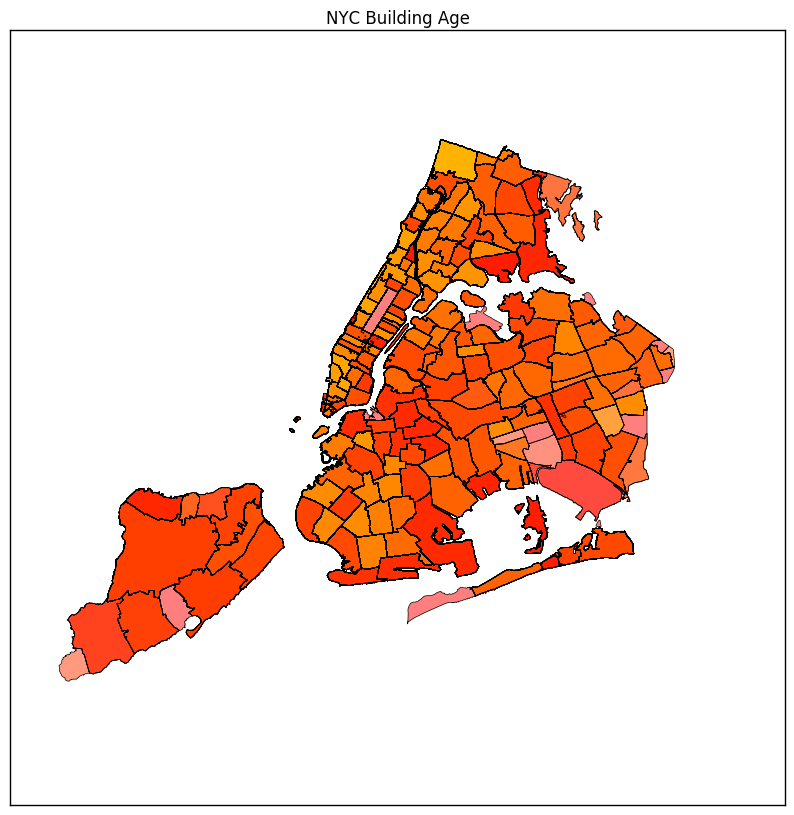

In [72]:
f, ax = plt.subplots(figsize=(7, 7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('NYC Building Age')
energy.plot(column='Age', colormap='autumn', alpha=0.5,linewidth=0.5,ax=ax)

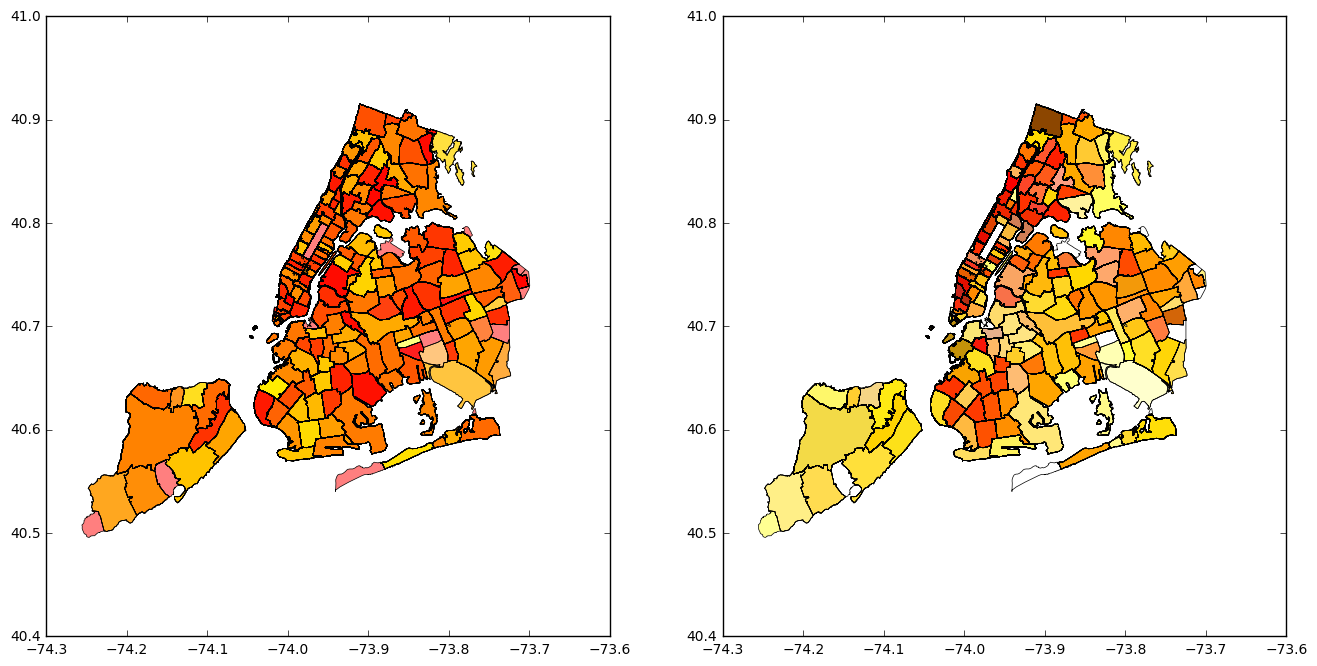

In [79]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
energy.plot(column='Score', colormap='autumn', alpha=0.5, linewidth=0.5, ax=ax1) 
energy.plot(column='Age', colormap='hot_r', alpha=0.5, linewidth=0.5, ax=ax2)

## A lot of zip code data missing. Should change colormap to look better. Staten Island seems to have higher scores

In [ ]:
asthma = pd.read_excel("Asthma.xlsx")

In [ ]:
len(pd.unique(asthma['Zip Code']))

In [ ]:
datazip = pd.merge(nrgzip, asthma, on='Zip Code', how='left')

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
energy.plot(column='Rate', colormap='hot_r', alpha=1,linewidth=0.5,ax=ax)

In [ ]:
asthmazip = energy.groupby(by='Zip Code').mean()
asthmazip.head(5)

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
asthmazip.plot(column='Rate', colormap='hot_r', alpha=1,linewidth=0.5,ax=ax)